In [1]:
from __future__ import print_function

In [2]:
import notebook
import warnings

#notebook.nbextensions.check_nbextension("usability/python-markdown/", user = True)
E = notebook.nbextensions.EnableNBExtensionApp()
E.enable_nbextension("usability/python-markdown/main")
warnings.filterwarnings('ignore')

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

#Machine Learning Engineer Nanodegree

##Project 5: Capstone Project

###1.0 Introduction

This documents presents results for the fifth project within the Machine Learning Engineer Nanodegree program. This assessment required the student to leverage exploratory analysis and machine learning techniques in order to understand a problem of their choice. For this assessment, we have chosen to analyze data from the MotoGP (<a href = "https://en.wikipedia.org/wiki/Grand_Prix_motorcycle_racing">wikipedia</a>) 2014 season, and to ultimately build a model which is capable of predicting winning riders.

####1.1 What is MotoGP?

The MotoGP World Championship is the premier class of motorcycle road racing. It is currently divided into three classes: MotoGP, Moto2 and Moto3. The motorcycles used in each class are purpose-built racing machines that are neither available for purchase by the general public nor able to be ridden legally on public roads. All classes use four-stroke motorcycles, with the current engine capacities being 1,000 cc for MotoGP, 600cc for Moto2 and 250cc for Moto3.

####1.2 What is aim of this assessment?

The goal of this assessment is to build a machine learning based prediction model which is able to predict the winning rider of a MotoGP race. Such a model would obviously be of interest to those involved in sports betting. However, this assessment takes a more broad approach, with a focus on uncovering variables which demonstrate predictive power for determining race winners, and providing an initial framework for the development of subsequent (and more specialized) predictive models.

####1.3 What is the approach?

Under this assessment, a number of data exploration techniques are first employed using data from the MotoGP 2014 season in order to identify any obvious relationships or key variables within the dataset. Following this, a number of machine learning models are then fitted and assessed based on an extended feature set of rider, track and weather characteristics, with the classified race winner used as the predictor variable. This assessment is divided over a number of sections, including those devoted to data exploration, model fitting, evaluation and validation. A more detailed explanation of approach and results can be found in each section. 

###2.0 Data

This analysis makes use of a variety of datasets relevant to the MotoGP 2014 season. Data was scraped from a variety of web sources and is spread over four tables:

- Session data (session): Data which describes each of the MotoGP 2014 sessions, including the track name, country in which the track is located, track length, and climate statistics.

- Qualifying results (qresult): Results from free practice, warm-up and qualifying sessions, including the riders qualifying place, best time, and top speed, for each of the MotoGP 2014 sessions.

- Race results (rresult): Results from each race, including the riders finishing place, best time, and top speed, for each of the MotoGP 2014 sessions.

- Rider data (rider): Data which describes each of the riders who participated over the MotoGP 2014 season, including the riders name, nationality, bike manufacturer, and team.

Headline statistics for each of these datasets are shown below.

In [4]:
import pandas as pd
import itertools, pandas.io.sql, sqlite3

df_session = pd.read_csv("data/session.csv", sep="\t", encoding="utf-8")
df_qresult = pd.read_csv("data/qresult.csv", sep="\t", encoding="utf-8")
df_rresult = pd.read_csv("data/rresult.csv", sep="\t", encoding="utf-8")
df_rider = pd.read_csv("data/rider.csv", sep="\t", encoding="utf-8")

conn = sqlite3.connect("data/motogp.db")

list_df = [df_session, df_qresult, df_rresult, df_rider]
list_tbl = ["session", "qresult", "rresult", "rider"]

for d, t in zip(list_df, list_tbl):
    dropQuery = "DROP TABLE IF EXISTS " + str(t)
    conn.execute(dropQuery).fetchone()
    pandas.io.sql.to_sql(d, t, conn)
    selQuery = "SELECT * FROM " + str(t)
    conn.execute(selQuery).fetchone()
    
conn.close()

In [5]:
import pandas, sqlite3

conn = sqlite3.connect("data/motogp.db")
curs = conn.cursor()  

d_session2014motogp = "DROP TABLE IF EXISTS session2014motogp"
d_qresult2014motogp = "DROP TABLE IF EXISTS qresult2014motogp"
d_rresult2014motogp = "DROP TABLE IF EXISTS rresult2014motogp"
d_rider2014motogp = "DROP TABLE IF EXISTS rider2014motogp"

temp = conn.execute(d_session2014motogp)
temp = conn.execute(d_qresult2014motogp)
temp = conn.execute(d_rresult2014motogp)
temp = conn.execute(d_rider2014motogp)

tblQuery = "SELECT name FROM sqlite_master WHERE type = 'table' ORDER BY Name"
curs.execute(tblQuery)
tables = map(lambda t: t[0], curs.fetchall())

totalColumns, totalRows, totalCells = 0, 0, 0
resultcols = ["Table Name", "Column Count", "Row (Record) Count", "Cell Count"]

results_df = pd.DataFrame([])

for table in tables:
    columnsQuery = "PRAGMA table_info(%s)" % table
    curs.execute(columnsQuery)
    numberOfColumns = len(curs.fetchall())
    rowsQuery = "SELECT Count() FROM %s" % table
    curs.execute(rowsQuery)
    numberOfRows = curs.fetchone()[0]
    numberOfCells = numberOfColumns * numberOfRows
    temp_df = pandas.DataFrame([[table, 
                                 numberOfColumns, 
                                 numberOfRows, 
                                 numberOfCells]], columns=resultcols)
    results_df = results_df.append(temp_df)

curs.close()
conn.close()

print("Table 1: Headline Dataset Statistics Table")
results_df.reset_index().drop("index", 1)

Table 1: Headline Dataset Statistics Table


,Table Name,Column Count,Row (Record) Count,Cell Count
0,qresult,9,82791,745119
1,rider,8,2933,23464
2,rresult,7,16728,117096
3,session,14,3790,53060


In [6]:
import pandas, sqlite3

conn = sqlite3.connect("data/motogp.db")
curs = conn.cursor()

c_session2014motogp = """
CREATE TABLE session2014motogp AS
SELECT * FROM session
WHERE (
session.sessionSeason = 2014 AND
session.sessionClass = "MotoGP"
)
"""

c_qresult2014motogp = """
CREATE TABLE qresult2014motogp AS
SELECT * FROM qresult
WHERE qresult.sessionId IN ( 
SELECT session2014motogp.sessionId FROM session2014motogp 
)
"""

c_rresult2014motogp = """
CREATE TABLE rresult2014motogp AS
SELECT * FROM rresult
WHERE rresult.sessionId IN ( 
SELECT session2014motogp.sessionId FROM session2014motogp 
)
"""

c_rider2014motogp = """
CREATE TABLE rider2014motogp AS
SELECT * FROM rider
WHERE rider.riderId IN ( 
SELECT qresult2014motogp.riderId FROM qresult2014motogp
) OR rider.riderId IN (
SELECT rresult2014motogp.riderId FROM rresult2014motogp
)
"""

temp = conn.execute(c_session2014motogp)
temp = conn.execute(c_qresult2014motogp)
temp = conn.execute(c_rresult2014motogp)
temp = conn.execute(c_rider2014motogp)
    
df_session2014motogp = pandas.io.sql.read_sql("SELECT * FROM session2014motogp", conn)
#df_session2014motogp = df_session2014motogp.drop(["index"], 1)

df_qresult2014motogp = pandas.io.sql.read_sql("SELECT * FROM qresult2014motogp", conn)
#df_qresult2014motogp = df_session2014motogp.drop(["index"], 1)

df_rresult2014motogp = pandas.io.sql.read_sql("SELECT * FROM rresult2014motogp", conn)
#df_rresult2014motogp = df_session2014motogp.drop(["index"], 1)
    
df_rider2014motogp = pandas.io.sql.read_sql("SELECT * FROM rider2014motogp", conn)
#df_rider2014motogp = df_session2014motogp.drop(["index"], 1)
    
curs.close()
conn.close()

Do note that the datasets included for this assessment cover a number of properties which could have a relationship with rider performance. There are rider specific characteristics (i.e. nationality), team characteristics (i.e. type of bike), and session characteristics (i.e. temperature). The breadth of data provides a number of dimensions for data exploration, and the potential to discover some less obvious data relationships (i.e. does a particular rider or team favour a particular track or type of weather?).

A summary table of the list of columns for each dataset is shown below.

In [7]:
list_datasummary = [df_session2014motogp.columns,
                    df_qresult2014motogp.columns,
                    df_rresult2014motogp.columns,
                    df_rider2014motogp.columns]

df_datasummary = pd.DataFrame(list_datasummary).T
df_datasummary.columns = ["session", "qresult", "rresult", "rider"]

print("Table 2: Dataset Columns")
df_datasummary[2:]

Table 2: Dataset Columns


,session,qresult,rresult,rider
2,sessionId,sessionId,sessionId,riderId
3,sessionSeason,riderId,riderId,riderName
4,sessionCountry,qresultPlace,rresultPlace,riderNumber
5,sessionTrackname,qresultBesttime,rresultTotaltime,riderNationality
6,sessionClass,qresultBestlap,rresultTopspeed,riderTeam
7,sessionSession,qresultTotallap,None,riderMotortype
8,sessionDate,qresultTopspeed,None,None
9,sessionTracklength,None,None,None
10,sessionWeathertype,None,None,None
11,sessionAirtemp,None,None,None


There are some obvious shortcomings with employing only a single season's worth of data. For example, riders often sign one to two year contracts, which may see them riding with a different team or potentially even a different type of bike at the end of that contract. Additionally, the line-up of manufacturers and teams does vary between seasons, as well as the roster of tracks for races. Noting this, an obvious means to build on the analysis would be to include additional seasons worth of data. Fortunately, the 'rider' dataset is conveniently identified by not only the riders name, but the combination of their current team and motortype in order to ensure result relevance over multiple seasons.

###3.0 Exploratory Analysis

We begin the exploratory analysis routine by identifying counts of key variables within the dataset.

In [8]:
ntracks = len(df_session2014motogp["sessionTrackname"].unique())
nsession = len(df_session2014motogp["sessionSession"].unique())
nrider = len(df_rider2014motogp["riderId"].unique())
nteam = len(df_rider2014motogp["riderTeam"].unique())
nmotor = len(df_rider2014motogp["riderMotortype"].unique())

list_datastats = [["Number of tracks", 
                   "Sessions at each track", 
                   "Number of riders", 
                   "Number of teams", 
                   "Number of manufacturers"],
                  [ntracks, nsession, nrider, nteam, nmotor]]

df_datastats = pd.DataFrame(list_datastats).T
df_datastats = df_datastats.set_index(0)
df_datastats.index.name = None
df_datastats.columns = ["Count"]

print("Table 3: Count of Key Variables")
df_datastats

Table 3: Count of Key Variables


,Count
Number of tracks,18
Sessions at each track,8
Number of riders,31
Number of teams,17
Number of manufacturers,8


Note that the number of riders presented above includes riders who may have only participated in a single session. These riders may have been stand-in riders for those injured, or wild card riders who are given the opportunity to enter during sessions held at their home circuit. 

####3.1 Session Data

The 'session' dataframe contains track length data for each track within the MotoGP 2014 season. Below shows a summary of the shortest, longest and average track lengths.

In [9]:
df_session2014motogprace = df_session2014motogp[df_session2014motogp["sessionSession"] == "RAC"]

mintracklength = df_session2014motogprace["sessionTracklength"].min()
maxtracklength = df_session2014motogprace["sessionTracklength"].max()
meantracklength = df_session2014motogprace["sessionTracklength"].mean()

minlengthtrackname = df_session2014motogprace.loc[df_session2014motogprace["sessionTracklength"] == mintracklength]["sessionTrackname"].values[0]
maxlengthtrackname = df_session2014motogprace.loc[df_session2014motogprace["sessionTracklength"] == maxtracklength]["sessionTrackname"].values[0]

print("Shortest track (meters):", minlengthtrackname, mintracklength)
print("Longest track (meters):", maxlengthtrackname, maxtracklength)
print("Average track length (meters):", meantracklength)

Shortest track (meters): Sachsenring 3671.0
Longest track (meters): Silverstone Circuit 5900.0
Average track length (meters): 4781.444444444444


As seen in the chart below, there is a large variation in length over each track, with the longest track, Silverstone, being over two kilometres longer than the shortest track, Sachsenring. It is worth noting that tracks with sweeping corners and longer straights may benefit bike manufacturers which have a top speed advantage, while tighter tracks with shorter straights may benefit bike manufacturers which have an advantage under breaking and acceleration. 

Figure 1: Track Length Comparison


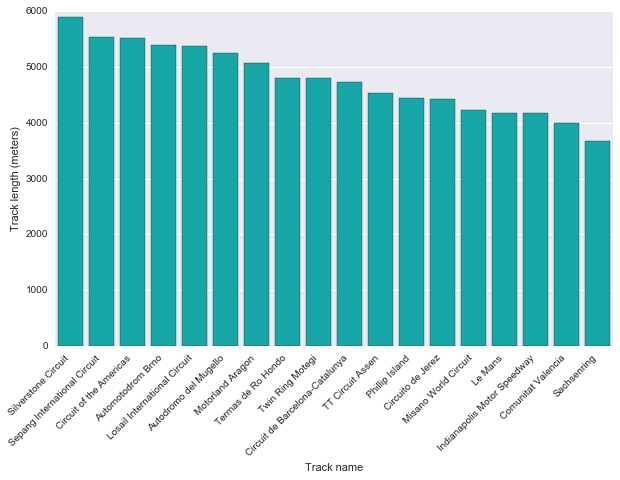

In [10]:
#!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df_temp = df_session2014motogprace.sort_values(by="sessionTracklength", ascending=False)

fig = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x="sessionTrackname", y="sessionTracklength", data=df_temp, color="c")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

#ax.set_title("Figure 1: Track Length Comparison")
ax.set_ylabel("Track length (meters)")
ax.set_xlabel("Track name")

print("Figure 1: Track Length Comparison")
plt.show()

We can observe that longer tracks do generally allow for greater maximum speed by plotting the maximum speed each rider achieved over each race session against track length.

Figure 2: Top Speed vs. Track Length


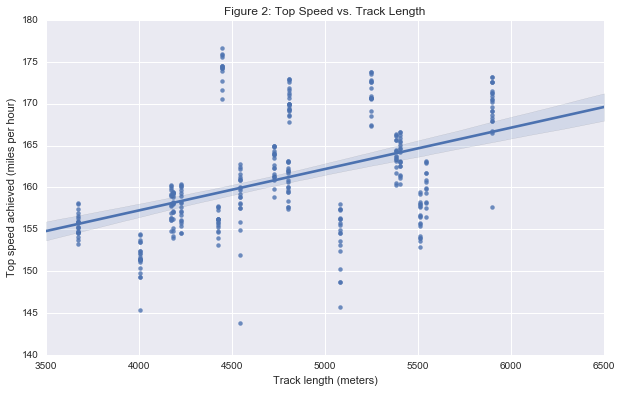

In [11]:
#!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

dict_sessionidtracklength = df_session2014motogp.set_index("sessionId")["sessionTracklength"].to_dict()
df_temp = df_rresult2014motogp[["sessionId", "rresultTopspeed"]].replace({"sessionId": dict_sessionidtracklength})
df_temp.columns = ["sessionTracklength", "rresultTopspeed"]

fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x="sessionTracklength", y="rresultTopspeed", data=df_temp)
ax.set_title("Figure 2: Top Speed vs. Track Length")
ax.set_ylabel("Top speed achieved (miles per hour)")
ax.set_xlabel("Track length (meters)")

print("Figure 2: Top Speed vs. Track Length")
plt.show()

The 'session' dataframe also contains climate data for each session of the MotoGP 2014 season. Below shows a summary of the lowest, highest and average air temperatures recorded over each session.

In [12]:
df_session2014motogprace = df_session2014motogp[df_session2014motogp["sessionSession"] == "RAC"]

mintrackairtemp = df_session2014motogprace["sessionAirtemp"].min()
maxtrackairtemp = df_session2014motogprace["sessionAirtemp"].max()
meantrackairtemp = df_session2014motogprace["sessionAirtemp"].mean()

minairtemptrackname = df_session2014motogprace.loc[df_session2014motogprace["sessionAirtemp"] == mintrackairtemp]["sessionTrackname"].values[0]
maxairtemptrackname = df_session2014motogprace.loc[df_session2014motogprace["sessionAirtemp"] == maxtrackairtemp]["sessionTrackname"].values[0]

print("Lowest air temperature over race session (degrees celsius):", minairtemptrackname, mintrackairtemp)
print("Highest air temperature over race session (degrees celsius):", maxairtemptrackname, maxtrackairtemp)
print("Average air temperature (degrees celsius):", meantrackairtemp)

Lowest air temperature over race session (degrees celsius): Phillip Island 16.0
Highest air temperature over race session (degrees celsius): Sepang International Circuit 36.0
Average air temperature (degrees celsius): 22.5


Sepang reported by far the greatest air temperature for race sessions over all tracks, while Phillip Island reported the lowest. As with track length, some bike manufacturers and riders may have an advantage when riding under certain weather conditions. 

Figure 3: Track Air Temperature Comparison


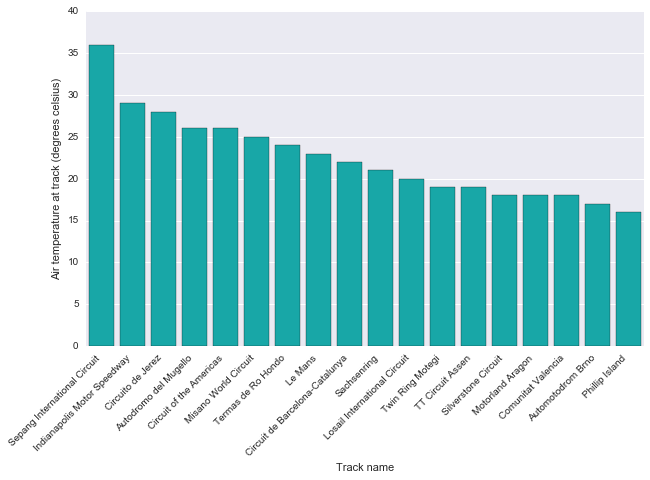

In [13]:
#!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df_temp = df_session2014motogprace.sort_values(by="sessionAirtemp", ascending=False)

fig = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x="sessionTrackname", y="sessionAirtemp", data=df_temp, color="c")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

#ax.set_title("Figure 3: Track Air Temperature Comparison")
ax.set_ylabel("Air temperature at track (degrees celsius)")
ax.set_xlabel("Track name")

print("Figure 3: Track Air Temperature Comparison")
plt.show()

Weather conditions at each session are also categorized under four different types depending on rainfall, these include 'dry', 'wet', 'wet-dry' and 'dry-wet'. A 'wet-dry' label indicates that the session started with rainfall which stopped at some later point during the same session, while a 'dry-wet' label indicates that the session started dry but had rain at some later point during the same session.

In [14]:
print("Number of 'dry' sessions:", df_session2014motogp.groupby("sessionWeathertype")["sessionWeathertype"].count()["Dry"])
print("Number of 'wet' sessions:", df_session2014motogp.groupby("sessionWeathertype")["sessionWeathertype"].count()["Wet"])
print("Number of 'wet-dry' sessions:", df_session2014motogp.groupby("sessionWeathertype")["sessionWeathertype"].count()["Wet-Dry"])

Number of 'dry' sessions: 135
Number of 'wet' sessions: 8
Number of 'wet-dry' sessions: 1


We can also observe the number of classified weather sessions for each track.

In [15]:
#df_session2014motogp.groupby(["sessionTrackname", "sessionWeathertype"])["sessionTrackname"].count()
df_session2014motogp.groupby(["sessionTrackname", "sessionWeathertype"]).size()

sessionTrackname                sessionWeathertype
Autodromo del Mugello           Dry                   7
                                Wet                   1
Automotodrom Brno               Dry                   7
                                Wet                   1
Circuit de Barcelona-Catalunya  Dry                   8
Circuit of the Americas         Dry                   8
Circuito de Jerez               Dry                   8
Comunitat Valencia              Dry                   8
Indianapolis Motor Speedway     Dry                   8
Le Mans                         Dry                   8
Losail International Circuit    Dry                   8
Misano World Circuit            Dry                   6
                                Wet                   2
Motorland Aragon                Dry                   7
                                Wet                   1
Phillip Island                  Dry                   8
Sachsenring                     Dry                  

Clearly the lack of observed 'wet' and 'wet-dry' sessions may limit the use of this feature within the final prediction model.

####3.2 Rider Results

As mentioned earlier, there were eight sessions held at each track over the MotoGP 2014 season. These sessions included four free practice sessions (FP1, FP2, FP3, FP4), two qualifying sessions (Q1, Q2), a warm-up session (WUP) and a race session (RAC). Sessions are held in this order.

Free practice sessions are intended to provide teams with an opportunity to test and optimize their bike setup to suit the track, qualifying sessions are held in order to determine the starting grid order, and finally, a warm-up session is held just before the race for each team to determine whether any final adjustments need to be made.

One common observation made over free practice sessions, is that riders generally improve their times over each session. Those riders who are able to find optimal bike settings the fastest, go on to improve their practice times and generally go on as favourites for qualifying sessions. The box and whisker plot below is intended to demonstrate this observation, by plotting the best lap time for each rider over each free practice session for Phillip Island.

Figure 4: Best Times over Free Practice Sessions for Phillip Island


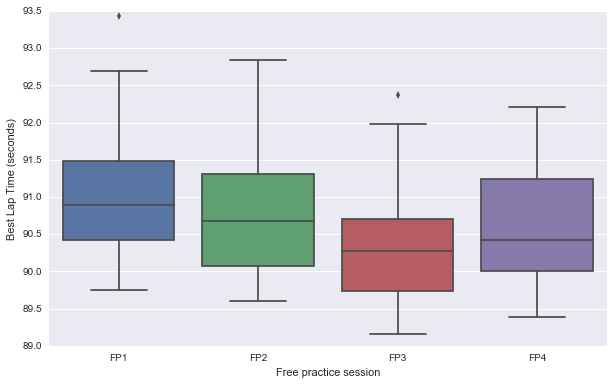

In [16]:
#!pip install seaborn
import re
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def convertdatetime(dt):
    f = "%Y-%m-%d %H:%M:%S.%f"
    r = re.compile(f)
    if dt == "nan" or r.match(dt) is not None:
        return np.NaN
    else:
        a = datetime.strptime(dt, f)
        b = datetime(1900, 1, 1)   
        return (a-b).total_seconds()


df_session2014motogpfpfp1 = df_session2014motogp[(df_session2014motogp["sessionTrackname"] == "Phillip Island") & (df_session2014motogp["sessionSession"] == "FP1")]
df_session2014motogpfpfp2 = df_session2014motogp[(df_session2014motogp["sessionTrackname"] == "Phillip Island") & (df_session2014motogp["sessionSession"] == "FP2")]
df_session2014motogpfpfp3 = df_session2014motogp[(df_session2014motogp["sessionTrackname"] == "Phillip Island") & (df_session2014motogp["sessionSession"] == "FP3")]
df_session2014motogpfpfp4 = df_session2014motogp[(df_session2014motogp["sessionTrackname"] == "Phillip Island") & (df_session2014motogp["sessionSession"] == "FP4")]

df_qresult2014motogpfpfp1 = df_qresult2014motogp[df_qresult2014motogp["sessionId"].isin(df_session2014motogpfpfp1["sessionId"])]
df_qresult2014motogpfpfp2 = df_qresult2014motogp[df_qresult2014motogp["sessionId"].isin(df_session2014motogpfpfp2["sessionId"])]
df_qresult2014motogpfpfp3 = df_qresult2014motogp[df_qresult2014motogp["sessionId"].isin(df_session2014motogpfpfp3["sessionId"])]
df_qresult2014motogpfpfp4 = df_qresult2014motogp[df_qresult2014motogp["sessionId"].isin(df_session2014motogpfpfp4["sessionId"])]

df_qresult2014motogpfpfp1 = df_qresult2014motogpfpfp1[["riderId", "sessionId", "qresultBesttime"]]
df_qresult2014motogpfpfp2 = df_qresult2014motogpfpfp2[["riderId", "sessionId", "qresultBesttime"]]
df_qresult2014motogpfpfp3 = df_qresult2014motogpfpfp3[["riderId", "sessionId", "qresultBesttime"]]
df_qresult2014motogpfpfp4 = df_qresult2014motogpfpfp4[["riderId", "sessionId", "qresultBesttime"]]

df_qresult2014motogpfpfp1 = df_qresult2014motogpfpfp1.set_index("riderId")
df_qresult2014motogpfpfp2 = df_qresult2014motogpfpfp2.set_index("riderId")
df_qresult2014motogpfpfp3 = df_qresult2014motogpfpfp3.set_index("riderId")
df_qresult2014motogpfpfp4 = df_qresult2014motogpfpfp4.set_index("riderId")

df_temp = pd.concat([df_qresult2014motogpfpfp1, 
                     df_qresult2014motogpfpfp2,
                     df_qresult2014motogpfpfp3,
                     df_qresult2014motogpfpfp4], axis=0)

dict_sessionidsession = df_session2014motogp.set_index("sessionId")["sessionSession"].to_dict()
df_temp.columns = ["sessionId", "qresultBesttime"]
df_temp = df_temp[["sessionId", "qresultBesttime"]].replace({"sessionId": dict_sessionidsession})

df_temp["qresultBesttime"] = df_temp.apply(lambda row: convertdatetime(row[1]), axis=1)

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x="sessionId", y="qresultBesttime", data=df_temp)
#ax.set_title("Figure 4: Best Times over Free Practice Sessions for Phillip Island")
ax.set_ylabel("Best Lap Time (seconds)")
ax.set_xlabel("Free practice session")

print("Figure 4: Best Times over Free Practice Sessions for Phillip Island")
plt.show()

Interestingly, this trend held true over the first three free practice sessions at Phillip Island, however there was a drop off in lap times set over the final session. One explanation is that, due to rules over the MotoGP 2014 season, it is the result during FP3 which dictates which qualifying session the rider will ultimately advance to. Those that perform well in FP3 are guaranteed to advance directly to Q2, and thus riders have an incentive to demonstrate their fastest times over this session. FP4 on the other hand, is achnowledged to be more representative of a riders 'race pace' (i.e. their lap time over a longer duration). It will be interesting to see whether FP3 or FP4 lap times have greater predictive power over race results.

Riders are awarded championship points depending on their final race result. Riders who achieve a first place result are awarded 25 points, a second place result is awarded 20 points, third is awarded 16 points and so forth. More information on the amount of points awarded for each position can be found on the <a href = "http://www.motogp.com">MotoGP website</a>.

Final results for each race session for the top five rides are shown in the table below. Note that a 'DNF' indicates that the rider failed to finish the race.

In [17]:
import pandas as pd
import numpy as np

list_rresult2014motogpsessionid = df_rresult2014motogp["sessionId"].unique()
dict_rideridname = df_rider.set_index("riderId")["riderName"].to_dict()

dict_sessionidcountry = df_session2014motogp.set_index("sessionId")["sessionCountry"].to_dict()

df_results = pd.DataFrame([])

for i in list_rresult2014motogpsessionid:
    df_temp = df_rresult2014motogp[df_rresult2014motogp["sessionId"] == i][["riderId", "rresultPlace"]]
    df_temp = df_temp[["riderId", "rresultPlace"]].replace({"riderId": dict_rideridname})
    df_temp = df_temp.set_index("riderId")
    df_temp.columns = [i]
    df_results = pd.concat([df_results, df_temp], axis=1)

df_results = df_results.rename(columns=dict_sessionidcountry)
df_results = df_results.replace(np.nan, "DNF", regex=True)
df_raceresults = df_results

#print("Table 4: MotoGP 2014 Race Results")
#df_raceresults

In [18]:
dict_champpoints = {1 : 25, 2 : 20, 3 : 16, 4 : 13, 5 : 11, 6 : 10, 7 : 9, 8 : 8, 9 : 7, 10 : 6, 
                    11 : 5, 12 : 4, 13 : 3, 14 : 2, 15 : 1, 16 : 0, 17 : 0, 18 : 0, 19 : 0, 20 : 0, 
                    21 : 0, 22 : 0, 23 : 0, 24 : 0, 25 : 0, 26 : 0, 27 : 0, 28 : 0, 29 : 0, 30 : 0, 
                    31 : 0, 32 : 0, 33 : 0, 34 : 0, 35 : 0, 36 : 0, 37 : 0, 38 : 0, 39 : 0, 40 : 0}

df_champpoints = df_results
df_champpoints = df_champpoints.replace("DNF", np.nan, regex=True)
df_champpoints = df_champpoints.replace(dict_champpoints)
df_champpoints["Total"] = df_champpoints.sum(axis=1)
df_champpoints = df_champpoints.sort_values(by="Total", ascending=False)
df_champpoints = df_champpoints.replace(np.nan, "DNF", regex=True)

print("Table 4: MotoGP 2014 Championship Points")
df_champpoints.head(5)

Table 4: MotoGP 2014 Championship Points


,QAT,AME,ARG,SPA,FRA,ITA,CAT,NED,GER,INP,CZE,GBR,RSM,ARA,JPN,AUS,MAL,VAL,Total
Marc MARQUEZ,25,25,25,25,25,25,25,25,25,25,13,25,1,3,20,DNF,25,25,362
Valentino ROSSI,20,8,13,20,20,16,20,11,13,16,16,16,25,DNF,16,25,20,20,295
Jorge LORENZO,DNF,6,16,13,10,20,13,3,16,20,20,20,20,25,25,20,16,DNF,263
Dani PEDROSA,16,20,20,16,11,13,16,16,20,13,25,13,16,2,13,DNF,DNF,16,246
Andrea DOVIZIOSO,11,16,7,11,8,10,8,20,8,9,10,11,13,DNF,11,13,8,13,187


Below shows a plot of cumulative championship points earnt by each of the final top five riders. Marc Marquez gains a huge lead over the early sessions of the championship scoring back-to-back wins for the first 10 sessions. It isn't until the second half of the season that Jorge Lorenzo and Valentino Rossi are able to start to close the gap on Marc.

Figure 4: Cumulative Championship Point


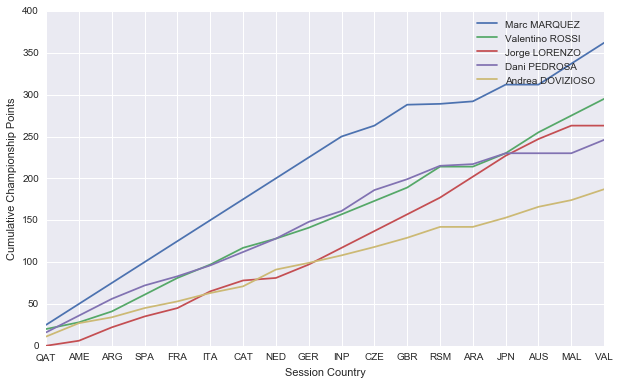

In [19]:
#!pip install seaborn
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

df_cumpoints = df_results
df_cumpoints = df_cumpoints.replace("DNF", np.nan, regex=True)
df_cumpoints = df_cumpoints.replace(dict_champpoints)
df_cumpoints = df_cumpoints.replace(np.nan, 0, regex=True)
df_cumpoints = df_cumpoints.cumsum(axis=1)
df_cumpoints["Total"] = df_cumpoints.sum(axis=1)
df_cumpoints = df_cumpoints.sort_values(by="Total", ascending=False)
df_cumpoints = df_cumpoints.drop("Total", 1)
df_cumpoints = df_cumpoints.sort_values(by="VAL", ascending=False)
df_cumpoints

df_temp = df_cumpoints[:5].T
df_temp = df_temp.reset_index()
list_sessionCountry = df_temp["index"].tolist()
df_temp = df_temp.drop("index", 1)

#sns.set_style("darkgrid")
df_temp.plot(figsize=(10, 6))
plt.xticks(np.arange(0, len(df_temp)), list_sessionCountry)
plt.ylabel("Cumulative Championship Points")
plt.xlabel("Session Country")
plt.legend()

print("Figure 4: Cumulative Championship Point")
plt.show()

The cumulative championship point score for each rider may have a bearing on future performance, particularly during the final rounds of the season. As such, the cumulative scores shown above have also been passed as to the feature set of the final model.

As mentioned previously, there were two qualifying sessions held at each track over the MotoGP 2014 season. The format of these qualifying sessions are quite unique in motorsport with new rules introduced during the 2013 season. Under the new rules, the top 10 fastest riders over FP3 go straight onto Q2, while the remaining riders participate in Q1. Of those riders who participate in Q1, the top two fastest riders under that session also compete against the 10 fastest riders during Q2. Qualifying results over both sessions are then aggregated to determine the starting grid position for all riders.

In [20]:
import pandas as pd
import numpy as np

def aggregateq1q2(q1, q2, n):
    if q1 > 2:
        return q1 + n
    else:
        return q2


list_session2014motogpqpsessionid = df_session2014motogp[(df_session2014motogp["sessionSession"] == "Q1") | (df_session2014motogp["sessionSession"] == "Q2")]["sessionId"].unique()
dict_rideridname = df_rider.set_index("riderId")["riderName"].to_dict()

dict_sessionidcountry = df_session2014motogp.set_index("sessionId")["sessionCountry"].to_dict()

df_qualresults = pd.DataFrame([])

for i in range(0, len(list_session2014motogpqpsessionid), 2):
    df_tempresults = pd.DataFrame([])
    for j in range(0, 2):
        qindex = list_session2014motogpqpsessionid[i + j]
        df_temp = df_qresult2014motogp[df_qresult2014motogp["sessionId"] == qindex][["riderId", "qresultPlace"]]
        df_temp = df_temp[["riderId", "qresultPlace"]].replace({"riderId": dict_rideridname})
        df_temp = df_temp.set_index("riderId")
        df_temp.columns = [qindex]
        df_tempresults = pd.concat([df_tempresults, df_temp], axis=1)
    n = float(df_tempresults[[qindex]].max().values - 2)
    df_tempresults[qindex] = df_tempresults.apply(lambda row: aggregateq1q2(row[qindex-1], row[qindex], n), axis=1)
    df_tempresults = df_tempresults.drop(qindex-1, 1)
    df_qualresults = pd.concat([df_qualresults, df_tempresults], axis=1)
      
df_qualresults = df_qualresults.rename(columns=dict_sessionidcountry)

df_qualresults = df_qualresults.replace(np.nan, "DNQ", regex=True)

#print("Table 6: MotoGP 2014 Aggregated Qualifying Results")
#df_qualresults

In [21]:
df_raceresults = df_raceresults.replace("DNF", np.nan, regex=True)
df_qualresults = df_qualresults.replace("DNQ", np.nan, regex=True)

for i in range(0, len(df_raceresults.index)):
    wins = 0
    poles = 0
    for j in range(0, len(df_raceresults.columns)):
        if df_qualresults.values[i,j] == 1 and df_raceresults.values[i,j] != np.nan:
            rider = df_raceresults.iloc[[i]].index.values[0]
            poles += 1
            if df_raceresults.values[i,j] == 1:
                wins += 1
    #if wins > 0:
        #print(rider, wins/poles)

###4.0 Building a Prediction Model

####4.1 Approach

There are a number of machine learning approaches that could be used to predict the winning rider of a MotoGP race. These approaches can be bucketed under either ranking algorithms, classifiers, or regression approaches. 

A ranking algorithm such as ordinal regression, tries to learn it's ordered rank (i.e. the final position of racers). However, this approach assumes independence over results. That is, it would generate the prediction of a particular rider's result without consideration of riders who have placed higher or lower than that rider. Applying a classification algorithm would also suffer from the same independence assumption, however, there may be scope to use measures of confidence of the prediction generated by the algorithm to rank results. Finally, a regression approach could be used to predict the riders total race time, or time behind the lead rider.

For this assessment, we decided to apply a classification approach to construct a model which predicts only the first place rider of each race rather than the entire final race result. Such an approach is well suited to the non-continuous nature of the majority of the datasets and can be expanded on later to include the use of confidence ranking to include predictions for the full range of rider results.

####4.2 Feature Selection

The array below shows the full feature set for consideration.

In [22]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)

# Create list of unique race and qualifying ids
list_qresult2014motogpsessionid = df_qresult2014motogp["sessionId"].unique()
list_rresult2014motogpsessionid = df_rresult2014motogp["sessionId"].unique()

#Create dictonary index for session id and race session id
dict_sessionidsession = df_session2014motogp.set_index("sessionId")["sessionSession"].to_dict()

dict_sessionidracsessionid = {}
for i in list_rresult2014motogpsessionid:
    sessioncountry = df_session2014motogp[df_session2014motogp["sessionId"] == i]["sessionCountry"].values[0]
    for j in range(-10, 10):
        if j != 0:
            if len(df_session2014motogp[(df_session2014motogp["sessionId"] == i+j) & \
                                        (df_session2014motogp["sessionCountry"] == sessioncountry)]) == 1:
                dict_sessionidracsessionid[i+j] = i
                
# Create temporary dataframe
df_temp = df_qresult2014motogp

# Add session type and race session id to qresults
df_temp["sessionId2"] = df_temp["sessionId"]
df_temp["sessionId3"] = df_temp["sessionId"]
df_temp = df_temp.replace({"sessionId2": dict_sessionidsession})
df_temp = df_temp.rename(columns={"sessionId2": "sessionSession"})
df_temp = df_temp.replace({"sessionId3": dict_sessionidracsessionid})
df_temp = df_temp.rename(columns={"sessionId3": "racsessionId"})

# Crete new race session id + rider id index
df_temp["racsessionriderId"] = df_temp["racsessionId"].map(str) + "_" + df_temp["riderId"].map(str)
df_temp = df_temp.drop(["index", "Unnamed: 0", "sessionId", "riderId", "racsessionId"], 1)

# Pivot table on new index and to new fields as needed
df_temp = df_temp.pivot(index="racsessionriderId", columns="sessionSession")
df_temp.columns = [str(x) + str(y) for x, y in list(df_temp.columns)]
df_temp = df_temp.reset_index()
df_ids = df_temp.racsessionriderId.str.split("_").apply(pd.Series)
df_ids.columns = ["racsessionId", "riderId"]
df_temp = pd.concat([df_temp, df_ids], axis=1)

# Drop race session id + rider id index
df_temp = df_temp.drop("racsessionriderId", 1)
df_temp = df_temp.rename(columns = {"racsessionId": "sessionId"})
df_temp[["sessionId", "riderId"]] = df_temp[["sessionId", "riderId"]].astype(float)

# Merge race result, rider and session data
df_temp = pd.merge(df_temp, df_rresult2014motogp, on=["riderId", "sessionId"], how="left")
df_temp = pd.merge(df_temp, df_rider2014motogp, on="riderId", how="left")
df_temp = pd.merge(df_temp, df_session2014motogp, on="sessionId", how="left")

# Drop unnecessary and non-feature fields
df_temp = df_temp.drop(["index",
                        "Unnamed: 0",
                        "index_x", 
                        "Unnamed: 0_x", 
                        "index_y", 
                        "Unnamed: 0_y",
                        "riderName",
                        "riderNumber",
                        "rresultTotaltime",
                        "rresultTopspeed",
                        "sessionId",
                        "sessionSeason",
                        "sessionClass",
                        "sessionCountry",
                        "sessionSession",
                        "sessionDate"], 1)

# Convert race result field to boolean
df_temp["rresultPlace"][df_temp["rresultPlace"] > 1] = 0
df_temp["rresultPlace"] = df_temp["rresultPlace"].fillna(0).astype(bool)

# Create label and features dataframe
df_label = pd.DataFrame(df_temp["rresultPlace"])
df_allfeatures = df_temp.drop("rresultPlace", 1)

#print(series_label)
print(df_allfeatures.columns)

Index(['qresultPlaceFP1', 'qresultPlaceFP2', 'qresultPlaceFP3',
       'qresultPlaceFP4', 'qresultPlaceQ1', 'qresultPlaceQ2',
       'qresultPlaceWUP', 'qresultBesttimeFP1', 'qresultBesttimeFP2',
       'qresultBesttimeFP3', 'qresultBesttimeFP4', 'qresultBesttimeQ1',
       'qresultBesttimeQ2', 'qresultBesttimeWUP', 'qresultBestlapFP1',
       'qresultBestlapFP2', 'qresultBestlapFP3', 'qresultBestlapFP4',
       'qresultBestlapQ1', 'qresultBestlapQ2', 'qresultBestlapWUP',
       'qresultTotallapFP1', 'qresultTotallapFP2', 'qresultTotallapFP3',
       'qresultTotallapFP4', 'qresultTotallapQ1', 'qresultTotallapQ2',
       'qresultTotallapWUP', 'qresultTopspeedFP1', 'qresultTopspeedFP2',
       'qresultTopspeedFP3', 'qresultTopspeedFP4', 'qresultTopspeedQ1',
       'qresultTopspeedQ2', 'qresultTopspeedWUP', 'riderId',
       'riderNationality', 'riderTeam', 'riderMotortype', 'sessionTrackname',
       'sessionTracklength', 'sessionWeathertype', 'sessionAirtemp',
       'sessionGroundtemp'

In terms of data pre-processing, no conditioning or standardization was applied to any of the numeric variables included within the above feature set. There was a need to convert time strings to date-time format, and to convert categorical variables to appropriate dummy variables, however both were able to be handled quite easily in Python.

In order to get some insight into the relevancy of features, the SelectKBest univariate feature selection algorithm was used, with an ANOVA F-value classification for ranking. This algorithm was applied to the full feature set.

In [23]:
import pandas as pd
import re

def convertdatetime(dt):
    f = "%Y-%m-%d %H:%M:%S.%f"
    r = re.compile(f)
    if dt == "nan" or r.match(dt) is not None:
        return np.NaN
    else:
        a = datetime.strptime(dt, f)
        b = datetime(1900, 1, 1)   
        return (a-b).total_seconds()

    
list_timecolumns = ["qresultBesttimeFP1",
                    "qresultBesttimeFP2",
                    "qresultBesttimeFP3",
                    "qresultBesttimeFP4",
                    "qresultBesttimeQ1",
                    "qresultBesttimeQ2",
                    "qresultBesttimeWUP"]

def preprocess_df(df_in):
    df_out = pd.DataFrame(index=df_in.index)
    for col, col_data in df_in.items():
        if col in list_timecolumns:
            col_data = col_data.astype(str)
            col_data = col_data.apply(convertdatetime)
        elif col_data.dtype == object:
            col_data = col_data.replace(["yes", "no"], [1, 0])
            col_data = pd.get_dummies(col_data, prefix=col)
        df_out = df_out.join(col_data)
    return df_out

df_allfeaturesprocessed = preprocess_df(df_allfeatures).fillna(0)
#df_allfeaturesprocessed.head()

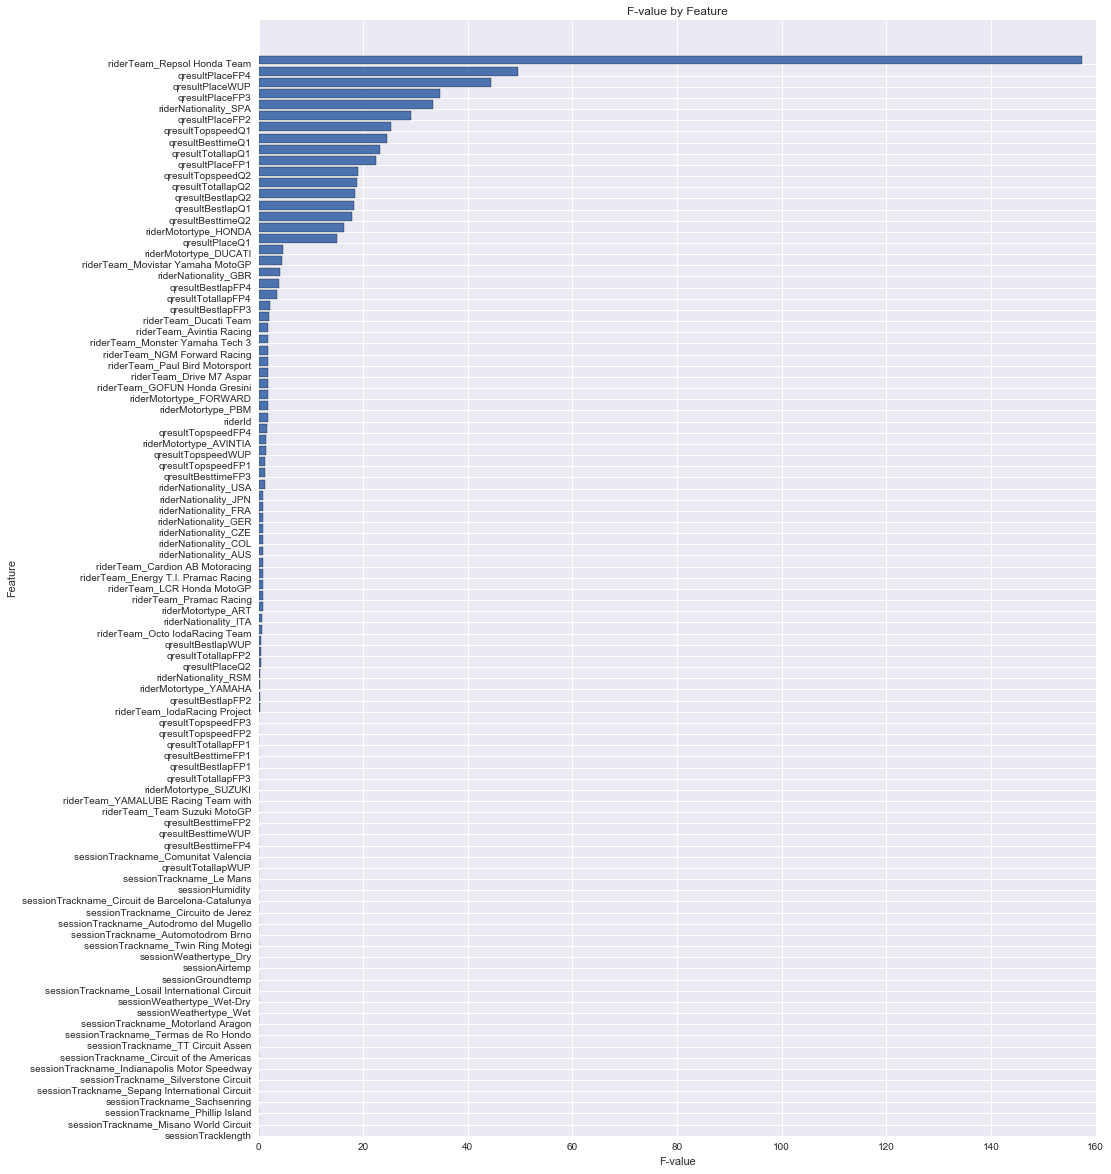

In [24]:
import numpy
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

list_features = df_allfeaturesprocessed.columns

kbsel = SelectKBest(k = 'all', score_func = f_classif).fit(df_allfeaturesprocessed, 
                                                           df_label.values.ravel())

#Create tables for the K-best features Anova F-value.
kbfeat = pandas.DataFrame([list_features, kbsel.scores_]).T
kbfeat.columns = ['Feature', 'Anova F-value']
kbfeat = kbfeat.sort(['Anova F-value'], ascending = True).reset_index(drop = True)

#Generate vertical bar chart
y = kbfeat['Feature']
y_pos = numpy.arange(len(y))
x = kbfeat['Anova F-value']

fig = plt.figure(figsize=(15, 20));
plt.barh(y_pos, x)
plt.yticks(y_pos, y)
plt.title("F-value by Feature")
plt.xlabel("F-value")
plt.ylabel("Feature")

Clearly, the impressive results set by Marc Marquez over the 2014 season are showing their influence on deciding the optimal feature selection. Marc Marquez belongs to the 'Repsol Honda' team, is Spanish ('SPA') and rides a bike manufactured by 'Honda'. Dummy features for each of these variables appear in the top 15 F-value features above. 

Interestingly, we can see that FP4 and WUP results have a greater relevance to the race result than FP3 or even Q1/Q2. We propose that this goes against mainstream opinion, which would largely rely on FP3 and final qualifying times to predict race winners. Also note the lack of relevance of the climate variables (i.e. temperature or weather type), however it would be beneficial to repeat this analysis over additional seasons in order to achnowledge a wider range of types of weather.

Noting the bias in features attributed to Marc Marquez's success over the 2014 season, the above F-value feature list was used as a guide to derive the final feature list, rather than being passed as the final list. By using the list as a guide, it is hoped that any subsequent model will show less feature bias and therefore be superior at generalizing over other seasons.

From the F-value feature list above, we can see that lap times, top speed and the rider team were all shown to be relevant and hence were included in the final features list, whilst track name, track length and climate variables were found to be not relevant, and hence were excluded from the final features list. The final list of features passed to the estimation proceedure are shown below.

In [25]:
import numpy

list_finalfeats = numpy.array(["qresultPlaceFP1",
                               "qresultPlaceFP2",
                               "qresultPlaceFP3",
                               "qresultPlaceFP4",
                               "qresultPlaceQ1",
                               "qresultPlaceQ2",
                               "qresultPlaceWUP",
                               "qresultBestlapQ1",
                               "qresultBestlapQ2",
                               "qresultTopspeedQ1",
                               "qresultTopspeedQ2",
                               "riderId",
                               "riderTeam_Avintia Racing",
                               "riderTeam_Cardion AB Motoracing",
                               "riderTeam_Drive M7 Aspar",
                               "riderTeam_Ducati Team",
                               "riderTeam_Energy T.I. Pramac Racing",
                               "riderTeam_GOFUN Honda Gresini",
                               "riderTeam_IodaRacing Project",
                               "riderTeam_LCR Honda MotoGP",
                               "riderTeam_Monster Yamaha Tech 3",
                               "riderTeam_Movistar Yamaha MotoGP",
                               "riderTeam_NGM Forward Racing",
                               "riderTeam_Octo IodaRacing Team",
                               "riderTeam_Paul Bird Motorsport",
                               "riderTeam_Pramac Racing",
                               "riderTeam_Repsol Honda Team",
                               "riderTeam_Team Suzuki MotoGP",
                               "riderTeam_YAMALUBE Racing Team with"])

df_finalfeatures = df_allfeaturesprocessed[list_finalfeats]
print(df_finalfeatures.columns)

Index(['qresultPlaceFP1', 'qresultPlaceFP2', 'qresultPlaceFP3',
       'qresultPlaceFP4', 'qresultPlaceQ1', 'qresultPlaceQ2',
       'qresultPlaceWUP', 'qresultBestlapQ1', 'qresultBestlapQ2',
       'qresultTopspeedQ1', 'qresultTopspeedQ2', 'riderId',
       'riderTeam_Avintia Racing', 'riderTeam_Cardion AB Motoracing',
       'riderTeam_Drive M7 Aspar', 'riderTeam_Ducati Team',
       'riderTeam_Energy T.I. Pramac Racing', 'riderTeam_GOFUN Honda Gresini',
       'riderTeam_IodaRacing Project', 'riderTeam_LCR Honda MotoGP',
       'riderTeam_Monster Yamaha Tech 3', 'riderTeam_Movistar Yamaha MotoGP',
       'riderTeam_NGM Forward Racing', 'riderTeam_Octo IodaRacing Team',
       'riderTeam_Paul Bird Motorsport', 'riderTeam_Pramac Racing',
       'riderTeam_Repsol Honda Team', 'riderTeam_Team Suzuki MotoGP',
       'riderTeam_YAMALUBE Racing Team with'],
      dtype='object')


####4.3 Estimation

In order to select the optimal set of estimation algorithm for the final predictive model, a GridSearchCV Pipeline was conducted. According to the sklearn documentation, GridSearchCV implements a 'fit' and 'predict' method like any classifier except that the parameters of the classifier used to predict are optimized by cross-validation.

For this analysis, a collection of pre-processors and estimators were added to a list which was passed to the GridSearchCV. Pre-processors and estimators included within the list and their parameter optimization ranges are noted below.

Pre-processors:

- SelectKBest(

        'k':[2, 4, 6, 8, 10, 12, 14, 16, 'all']

    )

Estimators:

- GaussianNB()

- SVC(

        'kernel': ["poly", "rbf"],
        'C':[0.05, 0.025, 0.5, 1, 10, 10^2],
        'tol':[10^-1, 10^-2, 10^-4, 10^-8],
        'class_weight':['auto']

    )

- DecisionTreeClassifier(

        'criterion':['gini', 'entropy'],
        'splitter':['best', 'random'],
        'min_samples_split':[1, 2, 3],
        'max_depth':[None, 2, 4, 6, 8, 10, 15, 20]

    )
    
- RandomForestClassifier(

        'n_estimators':[5, 10, 15, 20],
        'criterion':['gini', 'entropy'],
        'min_samples_split':[1, 2, 3],
        'max_depth':[None, 2, 4, 6, 8, 10, 15, 20]

    )

Although we have already generated a final feature list as part of the feature selection routine, we have elected to retain a SelectKBest pre-processor as part of the GridSearchCV Pipeline. Doing so will ensure that only the k-best features (of the already filtered final features list) are passed through for each loop of the GridSearchCV routine, ensuring that irrelevant features are omitted. This will reduce the burden of each estimator and should improve prediction accuracy.

Each estimator has its own set of advantages and disadvantages, these are explained further below. By passing each through to the GridSearchCV routine, we are able to then make an assessment of which estimator is able to maximize our desired performance metric.

<b>GaussianNB</b>

According to <a href = "http://scikit-learn.org/stable/modules/naive_bayes.html">scikit learn</a>, Naive Bayes (NB) methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of independence between every pair of features.

Strengths:

    - Naive Bayes learners and classifiers can be extremely fast compared to more sophisticated methods.
    - Low memory usage.
    - Decoupling of the class conditional feature distributions can help alleviate problems stemming from the curse of dimensionality.

Weaknesses:

    - Known to be a bad estimator.

<b>Support Vector Machine</b>

According to <a href = "http://scikit-learn.org/stable/modules/svm.html#svm">scikit learn</a>, Support Vector Machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection. SVMs use a linear hyperplane in order to separate data point, but can also be used as a non-linear classified through the use of kernels.

Strengths:

    - Low memory usage, as it only needs to store a subset of the data to make predictions.
    - SVM is effective in high dimensional spaces.
    - Versatile, as the kernel allows expert knowledge of the problem to be built into the classifier.

Weaknesses:

    - Slow training and testing phases.

<b>Decision Tree</b>

According to <a href = "http://scikit-learn.org/stable/modules/tree.html#tree">scikit learn</a>, Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

Strengths:

    - Fast training and testing phases.
    - Low memory usage.
    - Simple to understand and interpret.
    - Implicitly performs variable screening or feature selection.

Weaknesses:

    - Has the tendency to overfit data.

<b>Random Forest</b>

According to <a href = "http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier">scikit learn</a>, random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

Do note the range of tuning parameters for both the SelectKBest pre-processor, and the list of estimators shown above. Tuning parameters allow the user to optimize the models performance over desired performance criteria. For example, a certain set of parameters may allow more information to be extracted from a given set of features (varying validation scores as a result) while another set may allow for lower amount of computational processing. Each parameter range has been passed through to a GridSearchCV pipeline.

####4.4 Optimization Criteria

In order for GridSearchCV to select the optimal set of parameters, we must nominate an optimization criterion. There are a number of performance metrics for which we can optimize by. Precision for example, can be thought of as the ratio of how often the model is correct in identifying a positive label to the total times it guesses a positive label, while recall can be thought of as the ratio of how often the model correctly identifies a label as positive to how many total positive labels there actually are. A visualization referencing precision and recall is shown below.

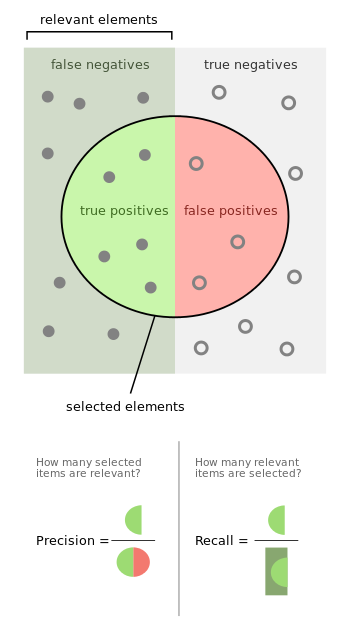

In [26]:
from IPython.display import Image

Image(filename='figures/precisionrecall.png') 

It is arguable that someone who were to a prediction model for sports betting may have a bias towards minimizing Type I errors (in order to minimize bad bets). However, this assessment has taken a more general approach to model optimization, acknowledging that its analysis can be extended on for a variety of purposes. We have therefore elected to optimize according to F1 score. The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

    F1 = 2 * (precision * recall) / (precision + recall)

It is worth noting that this assessment does still acknowledge precision and recall of each model as part of the final model selection routine. However, GridSearchCV has been set to optimize according to the F1 score for feature selection under the SelectKBest routine, as well as parameter optimization for each estimator. This result is the estimation of four separate pipelines (one for each estimator), all of which are optimized by the same F1 score, but assessed in the context of balance between precision, recall and F1 score.

In [27]:
#GridSearchCV estimation library
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


def build_clf_list(clf_select):
    ref_list = []
    clf_list = []
    param_list = []

    if 1 in clf_select:
        ref = "minmax"
        clf = "MinMaxScaler()"
        param = {}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)
        
    if 2 in clf_select:
        ref = "skb"
        clf = "SelectKBest()"
        param = {"k":["all"]}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)
        
    if 3 in clf_select:
        ref = "knn"
        clf = "KNeighborsClassifier()"
        param = {}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)
        
    if 4 in clf_select:
        ref = "naive"
        clf = "GaussianNB()"
        param = {}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)
        
    if 5 in clf_select:
        ref = "svc"
        clf = "SVC()"
        param = {"kernel": ["poly", "rbf"],
                 "C": [0.05, 0.025, 0.5, 1, 10, 10**2],
                 "gamma": [0.0, 0.001, 0.0001, "auto"],
                 "class_weight":["balanced"]}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)
        
    if 6 in clf_select:
        ref = "linsvc"
        clf = "LinearSVC()"
        param = {"C":[0.05, 0.025, 0.5, 1, 10, 10**2],
                 "tol":[10**-1, 10**-2, 10**-4, 10**-8],
                 "class_weight":["balanced"]}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)
        
    if 7 in clf_select:
        ref = "svr"
        clf = "LinearSVR()"
        param = {}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)
        
    if 8 in clf_select:
        ref = "linsvr"
        clf = "LinearSVR()"
        param = {}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)
        
    if 9 in clf_select:
        ref = "dt"
        clf = "DecisionTreeClassifier()"
        param = {"criterion":["gini", "entropy"],
                 "splitter":["best", "random"],
                 "min_samples_split":[1, 2, 3],
                 "max_depth":[None, 2, 4, 6, 8, 10, 15, 20]}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)      
        
    if 10 in clf_select:
        ref = "rf"
        clf = "RandomForestClassifier()"
        param = {"n_estimators":[5, 10, 15, 20],
                 "criterion":["gini", "entropy"],
                 "min_samples_split":[1, 2, 3],
                 "max_depth":[None, 2, 4, 6, 8, 10, 15, 20]}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)
        
    if 11 in clf_select:
        ref = "lr"
        clf = "LogisticRegression()"
        param = {"C":[0.05, 0.025, 0.5, 1, 10, 10**2],
                 "tol":[10**-1, 10**-2, 10**-4, 10**-8],
                 "class_weight":["auto"]}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)
        
    if 12 in clf_select:
        ref = "pca"
        clf = "PCA()"
        param = {"n_components":[1, 2, 3, 4, 5],
                 "whiten":[True, False]}
        ref_list.append(ref)
        clf_list.append(clf)
        param_list.append(param)
        
    return ref_list, clf_list, param_list


def build_pipe(ref, clf, param):
    pipe_ref = []
    pipe_param = {}
    
    pipe_ref.append([ref, eval(clf)])
    
    for key, value in param.items():
        pipe_param[ref + "__" + key] = value
    
    return pipe_ref, pipe_param


def build_pipe_list(ref_list, clf_list, param_list):
    import itertools
    
    pipe_ref_list = []
    pipe_param_list = {}
    
    for ref, clf, param in zip(ref_list, clf_list, param_list):
        pipe_ref, pipe_param = build_pipe(ref, clf, param)
        
        pipe_ref_list.append([pipe_ref[0][0], pipe_ref[0][1]]) 
        pipe_param_list.update(pipe_param) 
    
    return pipe_ref_list, pipe_param_list


def optim_clf(clf, param, cv, feat, label):
    from sklearn.grid_search import GridSearchCV
    from sklearn.metrics import make_scorer
    from sklearn.metrics import f1_score
    
    f1score = make_scorer(f1_score)
    
    clf = GridSearchCV(clf, param, scoring = f1score, cv = cv)
    clf = clf.fit(feat, label)
    
    return clf.best_estimator_


def optim_clf_list(clf_list, param_list, cv, feat, label):
    import itertools
    
    clf_list_bestest = []
    
    for clf, param in zip(clf_list, param_list):
        clf.best_estimator_ = optim_clf(clf, param, cv, feat, label)
        clf_list_bestest.append(clf.best_estimator_) 
    
    return clf_list_bestest


def eval_clf(clf, feat, label): 
    from sklearn.metrics import f1_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import precision_score
    
    label_pred = clf.predict(feat) 
    
    f1score = f1_score(label, label_pred) 
    recall = recall_score(label, label_pred) 
    precision = precision_score(label, label_pred) 
    
    return f1score, recall, precision


def eval_clf_list(clf_list, feat, label): 
    clf_list_score = []
    
    for clf in clf_list: 
        f1score, recall, precision = eval_clf(clf, feat, label)
        clf_list_score.append([f1score, recall, precision]) 
    
    return clf_list_score

####4.5 Validation

Validation involves separating a dataset into two subsets of data, one for training and the other for testing. This allows you to train a prediction model on a training dataset and test the same model specification on a separate/independent dataset. This practice minimizes the potential for the model to overfit the data, which would translate into good in-sample performance, but poor out-of-sample performance.

For this assessment, 90% of the data was allocated as the training set (432 observations), and 10% as the test set (48 observations). Each of the various combinations of estimators were trained/tested against a cross-validation loop (StratifiedShuffleSplit) as part of the pipeline search. Do note that it is often desirable to split the data into three sets, allocated for development, testing and training. However, this assessment has maintained the aforementioned two sets of data, acknowledging that future assessments may want to adjust this validation assumption on the premise that they can access additional season data.

In [28]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV

np.random.seed(0)

X_all = df_allfeaturesprocessed[list_finalfeats]
y_all = df_label

#clf_select = [2,4] #F1 Score: 0.409090909091 Recall: 1.0 Precision: 0.257142857143
#clf_select = [2,5] #F1 Score: 0.787878787879 Recall: 0.722222222222 Precision: 0.866666666667
clf_select = [2,9] #F1 Score: 0.971428571429 Recall: 0.944444444444 Precision: 1.0
#clf_select = [2,10] #F1 Score: 0.909090909091 Recall: 0.833333333333 Precision: 1.0

ref_list, clf_list, param_list = build_clf_list(clf_select)

#pipe_ref, pipe_param = build_pipe(ref, clf, param)
pipe_ref_list, pipe_param_list = build_pipe_list(ref_list, clf_list, param_list)

pipe = Pipeline(pipe_ref_list)
param = pipe_param_list

cv = StratifiedShuffleSplit(y_all, test_size = 0.1)
grid_search = GridSearchCV(pipe, param, n_jobs = 1, cv = cv)
grid_search.fit(X_all, y_all.values.ravel())

clf = grid_search.best_estimator_
#print(clf)

param_bestest = grid_search.best_params_
#print(param_bestest)

f1score, recall, precision = eval_clf(clf, X_all, y_all)
#print("F1 Score:", f1score, "Recall:", recall, "Precision:", precision)                                     

Below shows the StratifiedShuffleSplit evaluation metrics for each of the evaluated estimators, post GridSearchCV parameter calibration:

<b>Pipe(SelectKBest, GaussianNB())</b>

    F1 Score: 0.409090909091 Recall: 1.0 Precision: 0.257142857143

<b>Pipe(SelectKBest, SVC())</b>

    F1 Score: 0.787878787879 Recall: 0.722222222222 Precision: 0.866666666667

<b>Pipe(SelectKBest, DecisionTreeClassifier())</b>

    F1 Score: 0.971428571429 Recall: 0.944444444444 Precision: 1.0

<b>Pipe(SelectKBest, RandomForestClassifier())</b>

    F1 Score: 0.909090909091 Recall: 0.833333333333 Precision: 1.0

The results above suggest a trade-off between precision and recall which must be balanced according to the desired priority evaluation metric. Of the above, the pipeline which included the DecisionTreeClassifier estimator was ultimately selected due to its more favourable F1 score and relatively high precision. We are weary in interpreting this model further however, mainly due to the shortcomings in the dataset (i.e. the inclusion of only a single season's worth of data).

GridSearchCV provides an optimal set of parameters for the selected pipeline. The optimal parameters for both the SelectKBest pre-processor and DecisionTreeClassifier estimator are shown below.

- SelectKBest(

        'k':['all']

    )

- DecisionTreeClassifier(

        'criterion':['gini'],
        'splitter':['best'],
        'min_samples_split':[2],
        'max_depth':[6]

    )

For SelectKBest, the 'k' parameter determines the number of features to be included (default = 10). The optimal parameter 'k' parameter for the chosen pipeline was found to be 'all', therefore passing all of the available features through to the DecisionTreeClassifier. Do note however, that we did make an assessment of available features earlier in this assessment, electing to pass through only a subset of the total feature set.

For the DecisionTreeClassifier, the 'criterion' parameter determines the measure for quality of a split. Supported criteria are 'gini' for the Gini impurity and 'entropy' for the information gain (default = 'gini'). The 'splitter' parameter determines the strategy used to choose the split at each node. Supported strategies are 'best' to choose the best split and 'random' to choose the best random split (default = 'best'). The 'min_samples_split' parameter determines the minimum number of samples required to split an internal node (default = 2). And finally, the 'max_depth' parameter determines the maximum depth of the tree. If 'none', then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples (default = 'none').

For the above DecisionTreeClassifier, the 'max_depth' parameter was the only parameter found to deviate from its default value. Generally, this parameter is used to prevent overfitting i.e. creating overly complex trees. As such, one option may be to lower the maximum depth in order to provide greater confidence of the estimators ability to generalize over additional data. However, due to the lack of data available to this assessment, there has not been a large focus on assessing the estimators ability to generalize. We instead highlight this shortcoming as a means to expand on this assessment, where trails of limiting the maximum depth parameter would be of greater value.

Also note that the above results were found after making multiple adjustments to the parameter ranges for each estimator. As a first pass, each estimation was made allowing only default parameters to be passed to each estimator. This resulted in less favourable results for all estimators, with the RandomForestClassifer producing the most favourable F1 Score of 0.913. A wide range of parameters were then passed to each estimator, however the estimation time was found to suffer greatly, particularly for the SVC and RandomForestClassifier estimators. An interactive process was then followed to 'collapse' the parameter ranges for each estimator in order to achieve a superior F1 score, whilst ensuring reasonable estimation times.

####4.6 Benchmarking

As a final step, we perform a comparison of predictions made by the selected model against a simple benchmark model. The benchmark model predicts the winner of a race according to the rider who won the previous race. For the first race of the season, the benchmark model selects the winner of the previous season's championship. Note that Marc Marquez won the 2013 MotoGP championship, and therefore is predicted by the benchmark model as being the winner for the first round of the 2014 MotoGP championship. Clearly the benchmark model would produce a favourable accuracy measure over the 2014 season due to Marc Marquez winning 10 consecutive races. However, this analysis will place a greater focus on this models recall and precision.

In [29]:
# 1 TP from correctly predicting Marquez as first round winner 
tp = 1
fp = 0
tn = 0
fn = 0

for i in range(1, len(df_raceresults.columns), 1):
    pred = df_raceresults[df_raceresults.iloc[:,i-1] == 1].index[0]
    win = df_raceresults[df_raceresults.iloc[:,i] == 1].index[0]
    if win == pred:
        tp += 1 # 1 TP from correctly predicting winner
    else:
        fp += 1 # 1 FP from incorrectly predicting winner
        fn += 1 # 1 FN from incorrectly predicting winner

#tn = 480-(tp+fp+fn) # Derive TN from known total observations
        
recall = float(tp)/(tp+fn)
precision = float(tp)/(tp+fp)
f1score = 2 * (precision * recall) / (precision + recall)

#print("F1 Score:", f1score, "Recall:", recall, "Precision:", precision)  

Validation metrics for the selected pipeline against the benchmark model are shown below.

<b>Pipe(SelectKBest, DecisionTreeClassifier())</b>

    F1 Score: 0.971428571429 Recall: 0.944444444444 Precision: 1.0

<b>Benchmark</b>

    F1 Score: 0.6666666666666 Recall: 0.6666666666666 Precision: 0.6666666666666

We can see that the benchmark model suffers in terms of recall and precision, resulting in an inferior model to the selected pipeline which included the DecisionTreeClassifier estimator. Here, with the superior recall and precision of the DecisionTreeClassifier estimator, we have greater assurance that we are able to avoid false positives as well as false negatives. Even recall, which was shown to be the relatively lowest scoring criteria for the selected pipeline, is much larger when compared to the benchmark model.

Although we were able to validate the selected model against a number of metrics and employ some basic benchmarks, it would be desirable to expand on this routine by testing the models ability to generalize over additional season data. As noted previously, this assessment is limited to only the 2014 MotoGP season data, however gaining access to, and subsequently employing data for the 2015 season for example, will provide greater flexibility in employed validation measures, and therefore provide greater confidence of model estimations.

###5.0 Conclusion

For this assessment, we used data exploration techniques to confirm a number of obvious and not-so-obvious trends within the dataset. These included identifying a postive relationship between maximum speed and track length, and a drop in average lap times over each practice session. We were also able to make an assessment of which variable has the greatest predictive power over race results. Interestingly, we found that FP4 and WUP results seem to have a greater relevance in determining the race winner than do FP3 or qualifying results. We also found climate variables and track specific variables to be largely irrelevant for determining race winners.

Finally, we found that a GridSearchCV pipeline with a Select K-best feature selection pre-processor, and DecisionTreeClassifier estimator was able to generate the most favourable F1 score for determining race winners.

This assessment has noted a number of shortcomings as part of its analysis. Most noteably, this assessment was limited to only a single season of data. The lack of observations limits confidence in our estimator, and causes us to hesitate in drawing solid conclusions from results. 

Future assessments would benefit from including an additional seasons worth of data, reassessing the optimal feature set according to that data, and subsequently conducting a more detailed investigation of the estimators abilitiy to generalize. If those assessments were to maintain a DecisionTreeClassifier as the preferred estimator, then there may also be additional value in trialing lower values of the maximum depth parameter as part of this assessment.